<small><i>This notebook was create by Franck Iutzeler, Jerome Malick and Yann Vernaz (2016).</i></small>
<!-- Credit (images) Jeffrey Keating Thompson. -->

<center><img src="UGA.png" width="30%" height="30%"></center>
<center><h3>Master of Science in Industrial and Applied Mathematics (MSIAM)</h3></center>
<hr>
<center><h1>Convex and distributed optimization</h1></center>
<center><h2>Part I - Preliminaries (3h + 3h home work)</h2></center>

# Outline

In these hands-on exercices we will be focusing on manipulating Resilient Distributed Datasets (RDDs). We introduce `map`, `mapValues`, `reduce`, `reduceByKey`, `aggregateByKey`, `filter` and `join` to transform, aggregate, and connect datasets. Each function can be stringed together to do more complex tasks.

The first part deals with movieLens dataset. These datasets will be used to build a movie' recommendation system based on Non Negative Matrix Factorization (NMF) methodology (Part II). In this part we work together as __Q & A__ (Questions and Answers).

The second part (data processing of textual dataset) is your home work to perform.

In [1]:
# set up spark environment (Using Spark Local Mode)
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext("local[*]")

Every `SparkContext` launches a web UI, that displays useful information about the application. 

- A list of scheduler stages and tasks
- A summary of RDD sizes and memory usage
- Environmental information
- Information about the running executors

We can access this interface by simply opening http://localhost:4040 in a web browser.

# MovieLens dataset

We will work with ratings from users on movies, collected by [MovieLens](https://movielens.org). This dataset is pre-loaded under `data/movielens/`. For quick testing of your code, you may want to use a smaller dataset under `data/movielens/medium`, which contains 1 million ratings from 6000 users on 4000 movies.

We will use two files from this dataset: `ratings.dat` and `movies.dat`. All ratings are contained in the file `ratings.dat` and are in the following format:

```
UserID::MovieID::Rating::Timestamp
```
The movie information is in the file `movies.dat` and is in the following format:

```
MovieID::Title::Genres
```

Let's start with the data. Loading the dataset:
- [MovieLens 1M Dataset](http://grouplens.org/datasets/movielens/1m/ml-1m.zip) - 1 million ratings from 6000 users on 4000 movies.
- [MovieLens 20M Dataset](http://grouplens.org/datasets/movielens/20m/ml-20m.zip) - 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. 
- [MovieLens latest Dataset](http://grouplens.org/datasets/movielens/20m/ml-20m.zip) - 22 million ratings and 580,000 tag applications applied to 33,000 movies by 240,000 users.

__Question 1__
>Define two functions `parseRating` and `parseMovie` that parse a rating and a movie record.

In [2]:
def parseRating(line):
    """ Parse a rating record in MovieLens format UserID::MovieID::Rating::Timestamp
    Args:
        line (str): a line in the ratings dataset in the form of UserID::MovieID::Rating::Timestamp
    Returns:
        tuple: (UserID, MovieID, Rating)
    """
    print(line)
    fields = line.split("::")
    print(fields)
    return int(fields[0]), int(fields[1]), float(fields[2])

In [3]:
def parseMovie(line):
    """ Parse a movie record in MovieLens format MovieID::Title::Genres
    Args:
        entry (str): a line in the movies dataset in the form of MovieID::Title::Genres
    Returns:
        tuple: (MovieID, Title, Genres)
    """
    fields = line.split("::")
    return int(fields[0]), fields[1], fields[2]

__Question 2__

>Create two RDDs by 
* reading a file with <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=textfile#pyspark.SparkContext.textFile">`textFile`</a>
* using the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map">`map`</a> transformation operation with the above defined functions to create them
* assigning them a name with <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=setname#pyspark.RDD.setName">`setName`</a> (e.g. `movies` and `ratings` respectively).



In [4]:
# path to MovieLens dataset
movieLensHomeDir="../data/movielens/medium/"

In [5]:
# movies is an RDD of (movieID, title, genre)
moviesRDD = sc.textFile(movieLensHomeDir + "movies.dat")
moviesRDD = moviesRDD.map(parseMovie).setName('movies')
moviesRDD.name()

'movies'

In [6]:
# ratings is an RDD of (userID, movieID, rating)
ratingsRDD = sc.textFile(movieLensHomeDir + "ratings.dat")
ratingsRDD = ratingsRDD.map(parseRating).setName('ratings')
ratingsRDD.name()

'ratings'

__Note__ - In these lines of code, we are creating the `moviesRDD` and `ratingsRDD` variables (technically RDDs) and we are pointing to files (on your local PC). Spark’s lazy nature means that it doesn’t automatically compile your code. Instead, it waits for some sort of action occurs that requires some calculation.

__Question 3__

>Make your first transformation to get the number of ratings, distinct users and movies from the ratings RDD. (see the various native operations on <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=count#pyspark.RDD">RDDs</a> in the doc) <br/>
>Display several elements of each created RDDs.

In [7]:
numRatings = ratingsRDD.count()
numUsers = ratingsRDD.map(lambda x: x[0]).distinct().count()
numMovies  = moviesRDD.count()

print("numRatings = %d, numUsers = %d, numMovies = %d" % (numRatings, numUsers, numMovies))

numRatings = 1000209, numUsers = 6040, numMovies = 3883


__Question 4__

>Define two new RDDs containing only the movies for genre _Comedy_ and all movies that have _Comedy_ among other genres.<br/>
>Use the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.filter">`filter`</a> function which return a new RDD containing only the elements that satisfy a predicate.<br/>
>Use the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.subtract">`subtract`</a> function to retreive the movies that have  _Comedy_ in their genres but not only (That is the elements of the second RDD minus the ones in the first). Count them and exhibit a few of them.


In [8]:
onlyComedyMoviesRDD = moviesRDD.filter(lambda x: 'Comedy' == x[2])
allComedyMoviesRDD = moviesRDD.filter(lambda x: 'Comedy' in x[2])
notOnlyComedyMoviesRDD = allComedyMoviesRDD.subtract(onlyComedyMoviesRDD)

__Question 5__

>Investigate the different movies genres. Warning: Multiples genres should not be seen as new genres! For this:
* separate the genres by delimiter '|' using  <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap">`flatMap`</a>
* use the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.distinct">`distinct`</a> function which return a new RDD containing the distinct elements in this RDD.

>Count the number of different genres and print them.


In [9]:
nb_gen = moviesRDD.flatMap(lambda x: x[2].split("|")).distinct().count()

print('number of different genres = %d' % nb_gen)

number of different genres = 18


<!--
<a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduce">
<img align=left src="files/images/pyspark-page23.svg" width=500 height=500 />
</a>
-->

__Question 6__

>Get the average of all of the ratings. There are different solutions:
* use the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.mean">`mean`</a> built-in function
* use the <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduce">`reduce`</a> function and define you own function for summing two ratings

>Compare these approaches in terms of execution time by using `iPython`'s magic command <a href="https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit">`timeit`</a>.


In [10]:
%timeit ratingsRDD.map(lambda x: x[2]).mean()
%timeit ratingsRDD.map(lambda x: x[2]).reduce(lambda x, y: x + y) / ratingsRDD.count()
# print('ratings_mean = %f, avg_rating = %f' %(ratings_mean, avg_rating))

1 loop, best of 3: 15.2 s per loop
1 loop, best of 3: 20.7 s per loop



__Question 7__

> Get the average rating for each movie and user.<br/>


In [46]:
import numpy as np
ratingsByUserIntermediateRDD = ratingsRDD.groupBy(lambda x: x[0]).mapValues(list) # group by userID
ratingsByUserRDD = ratingsByUserIntermediateRDD.map(lambda x: (x[0], np.sum([x[1][i][2] for i in range(len(x[1]))]) \
                                                                                            / len(x[1])))
ratingsByMovieIntermediateRDD = ratingsRDD.groupBy(lambda x: x[1]).mapValues(list) # group by movieID
ratingsByMovieRDD = ratingsByMovieIntermediateRDD.map(lambda x: (x[0], np.sum([x[1][i][2] for i in range(len(x[1]))]) \
                                                                                            / len(x[1])))

__Question 8__

> Get top-$n$ movies with highest average ratings.<br/>
> Get top-$n$ Movies with highest average ratings and more than 500 reviews.<br/>
> Save results on Disk

In [60]:
import pickle

n = 10
takeNMovies = ratingsByMovieRDD.takeOrdered(n, key = lambda x: 1. / x[1])
print(takeNMovies)

ratingsByMovieInt500RevRDD = ratingsRDD.groupBy(lambda x: x[1]).mapValues(list).filter(lambda x: len(x[1]) >= 500)
ratingsByMovie500RevRDD = ratingsByMovieInt500RevRDD.map(lambda x: (x[0], np.sum([x[1][i][2] \
                                                                            for i in range(len(x[1]))]) / len(x[1])))
takeNMovies500Rev = ratingsByMovie500RevRDD.takeOrdered(n, key = lambda x: 1. / x[1])
print(takeNMovies500Rev)
type(takeNMovies500Rev)

with open('takeNMovies.txt', 'w') as fp:
    fp.write('\n'.join('%s %s' % x for x in takeNMovies))
    
with open('takeNMovies500Rev.txt', 'w') as fp:
    fp.write('\n'.join('%s %s' % x for x in takeNMovies500Rev))

[(1830, 5.0), (3172, 5.0), (3280, 5.0), (3382, 5.0), (3656, 5.0), (787, 5.0), (989, 5.0), (3233, 5.0), (3607, 5.0), (3881, 5.0)]
[(2019, 4.5605095541401273), (318, 4.554557700942973), (858, 4.524966261808367), (745, 4.5205479452054798), (50, 4.5171060011217046), (527, 4.510416666666667), (1148, 4.5079365079365079), (1198, 4.4777247414478918), (904, 4.4761904761904763), (260, 4.4536944165830823)]


__Question 9__

> Compute the sparsity of the rating matrix.

In [61]:
# we define sparsity as nb_nonzero_elems / nb_elems
nb_elems = numMovies * numUsers
nb_nonzero_elems = numRatings
sparsity = 1. * nb_nonzero_elems / nb_elems

print('sparsity = %f' % sparsity)

sparsity = 0.042647


__Question 10__

>Get the rating distribution and plot histogram.

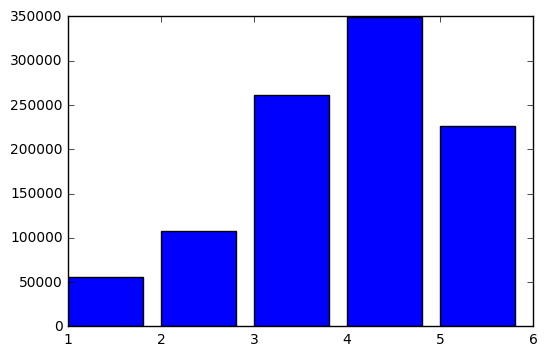

In [67]:
import matplotlib.pyplot as plt

ratingDistrib = ratingsRDD.groupBy(lambda x: x[2]).map(lambda x: (x[0], len(x[1]))).sortByKey().collect()
x = []
y = []
for rating in ratingDistrib:
    x.append(rating[0])
    y.append(rating[1])

plt.bar(x, y)
plt.show()

# LibSVM dataset (home work)


__Question 1__

> Examine the output of MLUtils's <a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.util.MLUtils.loadLibSVMFile">`loadLibSVMFile`</a> routine on the supervised classification datasets below.

The elements of the produced RDD have the form of <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint">`LabeledPoints`</a> composed of a label `example.label` corresponding to the class (+1 or -1) and a feature vector `example.features` generally encoded as a <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector">`SparseVector`</a>.

In [68]:
# path to ionosphere LibSVM
LibSVMHomeDir="../data/LibSVM/"
LibName="ionosphere.txt"
#LibName="rcv1_train.binary"

In [69]:
from pyspark.mllib.util import MLUtils
data = MLUtils.loadLibSVMFile(sc, LibSVMHomeDir + LibName).setName("LibSVM")

In [93]:
arr = data.take(1)[0]
arr.features

SparseVector(34, {0: 1.0, 2: 0.9954, 3: -0.0589, 4: 0.8524, 5: 0.0231, 6: 0.834, 7: -0.3771, 8: 1.0, 9: 0.0376, 10: 0.8524, 11: -0.1776, 12: 0.5976, 13: -0.4494, 14: 0.6054, 15: -0.3822, 16: 0.8436, 17: -0.3854, 18: 0.5821, 19: -0.3219, 20: 0.5697, 21: -0.2967, 22: 0.3695, 23: -0.4736, 24: 0.5681, 25: -0.5117, 26: 0.4108, 27: -0.4617, 28: 0.2127, 29: -0.3409, 30: 0.4227, 31: -0.5449, 32: 0.1864, 33: -0.453})

__Question 2__

>Count the the number of examples, the number of features, and the sparsity.

In [98]:
nb_examples = data.count()
nb_features = len(data.first().features)
val = data.map(lambda x: x.features.numNonzeros()).reduce(lambda x, y: x + y)
sparsity = 1 - 1. * val / (nb_examples * nb_features)

print('nb_examples = %d, nb_features = %d, sparsity = %f' % (nb_examples, nb_features, sparsity))

nb_examples = 351, nb_features = 34, sparsity = 0.884113


### __Question 3__

>Create your own LibSVM Reader file (you can use the number of features to simplify writing)

10551